In [77]:
from sklearn.neighbors import NearestNeighbors
import networkx as nx
import matplotlib.pyplot as plt

In [78]:
addresses = [
    "Mekelweg 4, 2628 CD Delft",
    "Markt 87, 2611 GS Delft",
    "Olof Palmestraat 1, 2616 LN Delft",
    "Troelstralaan 71, 2624 ET Delft",
    "Van Leeuwenhoeksingel 42A, 2611 AC Delft",
    "Kleveringweg 2, 2616 LZ Delft",
    "Schieweg 15L, 2627 AN Delft",
    "Westeinde 2A, 2275 AD Voorburg",
    "Herenstraat 101, 2271 CC Voorburg",
    "Haags Kwartier 55, 2491 BM Den Haag",
    "Spui 70, 2511 BT Den Haag",
    "Liguster 202, 2262 AC Leidschendam"
]

In [79]:
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
import time

# Initialize Nominatim API
geolocator = Nominatim(user_agent="hackathon")

# List of addresses
addresses = [
    "Mekelweg 4, 2628 CD Delft",
    "Markt 87, 2611 GS Delft",
    "Olof Palmestraat 1, 2616 LN Delft",
    "Troelstralaan 71, 2624 ET Delft",
    "Kleveringweg 2, 2616 LZ Delft",
    "Schieweg 15L, 2627 AN Delft",
    "Westeinde 2A, 2275 AD Voorburg",
    "Herenstraat 101, 2271 CC Voorburg",
    "Haags Kwartier 55, 2491 BM Den Haag",
    "Spui 70, 2511 BT Den Haag",
    "Liguster 202, 2262 AC Leidschendam"
]

# Function to get coordinates
def get_coordinates(address):
    try:
        location = geolocator.geocode(address)
        if location:
            return (location.latitude, location.longitude)
        else:
            return None
    except GeocoderTimedOut:
        return get_coordinates(address)

# Get coordinates for each address
coordinates = {address: get_coordinates(address) for address in addresses}

# Print the coordinates
for address, coord in coordinates.items():
    print(f"Address: {address} => Coordinates: {coord}")

Address: Mekelweg 4, 2628 CD Delft => Coordinates: (51.9988441, 4.3736485)
Address: Markt 87, 2611 GS Delft => Coordinates: (52.0115073, 4.358595)
Address: Olof Palmestraat 1, 2616 LN Delft => Coordinates: (52.0127665, 4.3811469)
Address: Troelstralaan 71, 2624 ET Delft => Coordinates: (51.9973499, 4.3512313)
Address: Kleveringweg 2, 2616 LZ Delft => Coordinates: (52.0266492, 4.3624455)
Address: Schieweg 15L, 2627 AN Delft => Coordinates: (51.9948117, 4.3667978)
Address: Westeinde 2A, 2275 AD Voorburg => Coordinates: (52.0648646, 4.3626176)
Address: Herenstraat 101, 2271 CC Voorburg => Coordinates: (52.0672856, 4.3636863)
Address: Haags Kwartier 55, 2491 BM Den Haag => Coordinates: (52.0627222, 4.3819389)
Address: Spui 70, 2511 BT Den Haag => Coordinates: (52.0779773, 4.3169084)
Address: Liguster 202, 2262 AC Leidschendam => Coordinates: (52.0877886, 4.3833151)


In [80]:
from sklearn.neighbors import kneighbors_graph
import numpy as np

def build_knn_graph(coordinates, k=3):
    """
    Build a k-NN graph from the given coordinates.

    Parameters:
    - coordinates (dict): A dictionary of address (key) to (latitude, longitude) (value).
    - k (int): The number of nearest neighbors.

    Returns:
    - G (networkx.Graph): The k-NN graph.
    """
    # Convert the coordinates to a NumPy array
    coordinates_list = list(coordinates.values())
    coords_array = np.array(coordinates_list)

    # Build the k-NN graph directly
    A = kneighbors_graph(coords_array, n_neighbors=k, mode='connectivity', include_self=False)

    # Convert the scipy sparse matrix to a networkx graph
    G = nx.from_scipy_sparse_array(A)

    # Add node attributes (address and position)
    for i, (address, (lat, lon)) in enumerate(coordinates.items()):
        G.nodes[i]['address'] = address
        G.nodes[i]['pos'] = (lon, lat)

    return G

In [81]:
def plot_knn_graph(G):
    """
    Plot the k-NN graph using networkx and matplotlib.

    Parameters:
    - G (networkx.Graph): The k-NN graph to plot.
    """
    pos = nx.get_node_attributes(G, 'pos')
    labels = nx.get_node_attributes(G, 'address')

    plt.figure(figsize=(10, 8))
    nx.draw(G, pos, with_labels=True, node_size=300, node_color='red', font_size=8, font_color='black', labels=labels)
    plt.title(f'k-Nearest Neighbors Graph')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

In [82]:
def duplicate_first_node(graph):
    # Get the first node in the graph
    first_node = list(graph.nodes)[0]
    
    # Create a new node with a unique identifier (assuming nodes are integers)
    new_node = max(graph.nodes) + 1
    
    # Copy the attributes of the first node to the new node
    graph.add_node(new_node, **graph.nodes[first_node])
    
    # Connect the new node to all the neighbors of the first node
    for neighbor in graph.neighbors(first_node):
        graph.add_edge(new_node, neighbor)
    
    # Optionally, connect the new node to the original node
    graph.add_edge(first_node, new_node)
    
    return graph

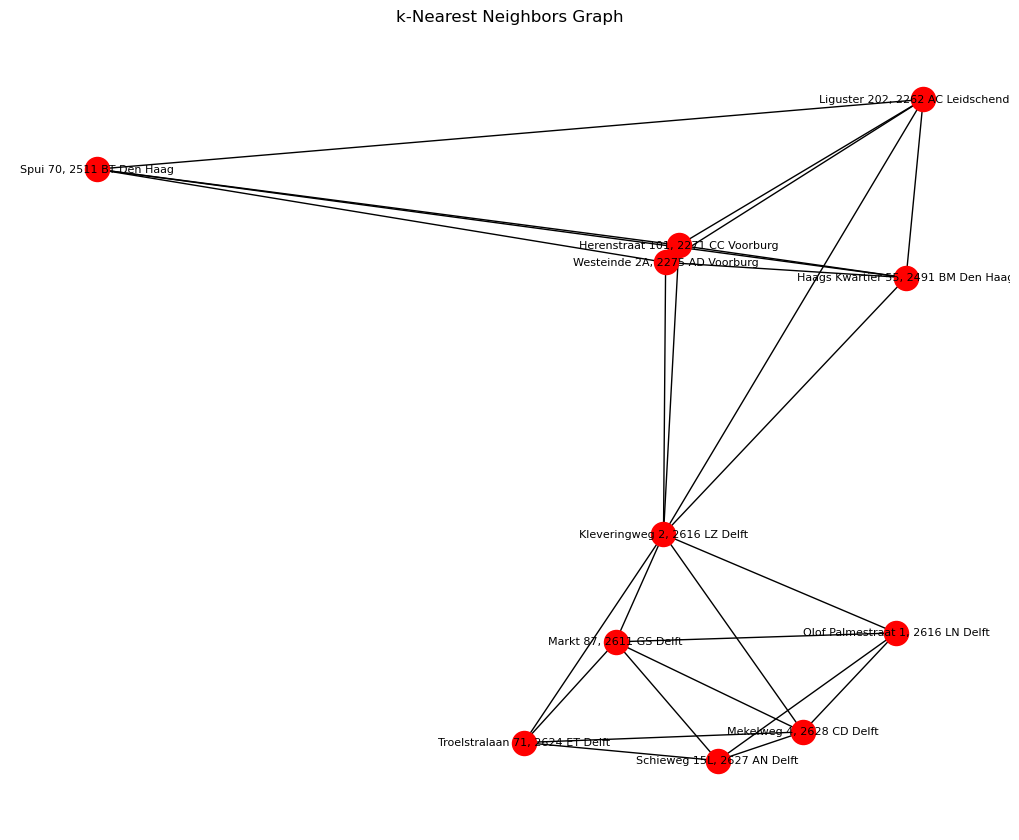

In [89]:
# Build the k-NN graph
k = 4  # Number of neighbors
G = build_knn_graph(coordinates, k)

#G = duplicate_first_node(G)
# Plot the k-NN graph
plot_knn_graph(G)

In [90]:
print(G.nodes[10])

{'address': 'Liguster 202, 2262 AC Leidschendam', 'pos': (4.3833151, 52.0877886)}


In [94]:
# Initialize the directed graph
DG = nx.DiGraph()

# Add nodes and their attributes from the undirected graph to the directed graph
for node, data in G.nodes(data=True):
    DG.add_node(node, **data)

# Add both directions for each edge in the undirected graph
for u, v in G.edges:
    if DG.nodes[u]['address'] != 'Mekelweg 4, 2628 CD Delft' and DG.nodes[v]['address'] != 'Mekelweg 4, 2628 CD Delft':
        DG.add_edge(u, v)
        DG.add_edge(v, u)

In [95]:
copy_node_data = G.nodes[0]
new_outgoing_node = 'source'
new_incoming_node = 'sink'
DG.add_node(new_outgoing_node, **copy_node_data)
DG.add_node(new_incoming_node, **copy_node_data)

# Connect the new outgoing node to all existing nodes with outgoing edges
for node in DG.nodes:
    if node != new_outgoing_node and node != new_incoming_node:
        DG.add_edge(new_outgoing_node, node)

# Connect the new incoming node to all existing nodes with incoming edges
for node in DG.nodes:
    if node != new_outgoing_node and node != new_incoming_node:
        DG.add_edge(node, new_incoming_node)

In [96]:
# Initialize lists for origins and destinations
origins = []
destinations = []

# Iterate through all edges
for edge in DG.edges:
    origin, destination = edge
    origins.append(DG.nodes[origin]['pos'])
    destinations.append(DG.nodes[destination]['pos'])

# Print the lists of origins and destinations
print("Origins:", origins)
print("Destinations:", destinations)
print(len(origins))

Origins: [(4.3736485, 51.9988441), (4.358595, 52.0115073), (4.358595, 52.0115073), (4.358595, 52.0115073), (4.358595, 52.0115073), (4.358595, 52.0115073), (4.3811469, 52.0127665), (4.3811469, 52.0127665), (4.3811469, 52.0127665), (4.3811469, 52.0127665), (4.3512313, 51.9973499), (4.3512313, 51.9973499), (4.3512313, 51.9973499), (4.3512313, 51.9973499), (4.3624455, 52.0266492), (4.3624455, 52.0266492), (4.3624455, 52.0266492), (4.3624455, 52.0266492), (4.3624455, 52.0266492), (4.3624455, 52.0266492), (4.3624455, 52.0266492), (4.3624455, 52.0266492), (4.3667978, 51.9948117), (4.3667978, 51.9948117), (4.3667978, 51.9948117), (4.3667978, 51.9948117), (4.3626176, 52.0648646), (4.3626176, 52.0648646), (4.3626176, 52.0648646), (4.3626176, 52.0648646), (4.3626176, 52.0648646), (4.3626176, 52.0648646), (4.3636863, 52.0672856), (4.3636863, 52.0672856), (4.3636863, 52.0672856), (4.3636863, 52.0672856), (4.3636863, 52.0672856), (4.3636863, 52.0672856), (4.3819389, 52.0627222), (4.3819389, 52.06272

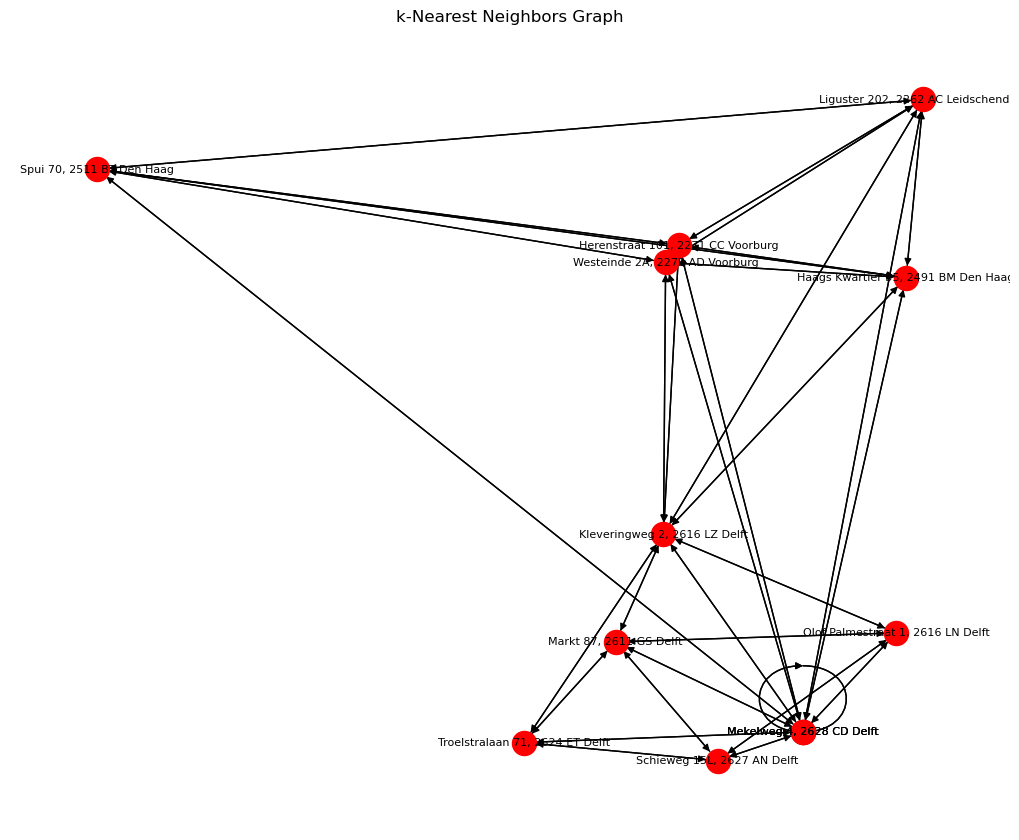

In [97]:
plot_knn_graph(DG)